In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.display import display
import matplotlib.dates as md #needed to convert time
import os
from matplotlib.colors import hsv_to_rgb
from matplotlib.patches import Polygon
import math

In [17]:
def plotdata(data):
    
    data["timestamp"] = pd.to_datetime(data["timestamp"])
    timestamps = md.date2num(data["timestamp"])
    plt.figure(figsize=(16,3))
    #plt.title("Loiter")
    plt.xticks( rotation=25 )
    ax=plt.gca()
    xfmt = md.DateFormatter('%Y-%m-%d %H:%M:%S')
    ax.xaxis.set_major_formatter(xfmt)
    ax.set_xlabel("Timestamp")
    ax.set_ylabel("Loitering [-]")
    plt.scatter(timestamps, data["loitering"], alpha = 1, marker = ".")
    plt.show()

In [18]:
def plottraj(data):
    #%matplotlib qt
    #plt.figure(file)
    fig, ax = plt.subplots()
    p = Polygon([[7.630, 47.334],
                 [7.630, 47.536],
                 [8.144, 47.536],
                 [8.144, 47.334]], True, alpha=0.5)
    ax.add_patch(p)
    p = Polygon([[8.334, 47.887],
                 [8.334, 48.086],
                 [8.536, 48.086],
                 [8.536, 47.887]], True, alpha=0.5)
    ax.add_patch(p)
    p = Polygon([[8.958, 47.564],
                 [8.958, 47.666],
                 [9.224, 47.666],
                 [9.224, 47.564]], True, alpha=0.5, label = "Loitering area")
    ax.add_patch(p)

    #groups = data.groupby('loitering')
    #for name, group in groups:
        #ax.scatter(group.longitude, group.latitude, marker='.', label=name)
    ax.scatter(data.loc[data["loitering"] == 0, "longitude"], data.loc[data["loitering"] == 0, "latitude"], marker='.', label="Not loitering", s = 17)
    ax.scatter(data.loc[data["loitering"] == 1, "longitude"], data.loc[data["loitering"] == 1, "latitude"], marker='.', label="Loitering", s = 19)
    ax.set_xlabel('longitude (deg)')
    ax.set_ylabel('latitude (deg)')
    ax.legend()

    #ax.scatter(temp.longitude, temp.latitude, c=, marker = ".")  # , alpha=0.01)

In [19]:
def prefilter(data, clustersize = 10):
# clustersize is the size of the bins
    
    filtereddata = data.copy(deep=True)

    for i in range(math.floor(len(data["loitering"])/clustersize)):    
        rows = data.iloc[0+clustersize*i:clustersize+clustersize*i]
        av = np.average(rows["loitering"])
        if av < 0.5: 
            filtereddata.iloc[0+clustersize*i:clustersize+clustersize*i]["loitering"] = 0
        elif av > 0.5:
            filtereddata.iloc[0+clustersize*i:clustersize+clustersize*i]["loitering"] = 1
    return filtereddata


In [20]:
def filtering(data, binsize0 = 15, binsizeouter = 15, dist = 15, step = 20):
# binsize0 is half of the size of the bin, so actual size is 30 sec
# same for binsizeouter, this is the size of the niehgbouring bins to which the bin is compared
# dist is the distance between the bin and the neighbouring bins, in this case half of the bins overlap
# step is the amount each iteration moves forward. In this case there is a little overlap

    filtereddata = data.copy(deep=True)

    for i in range(max(binsizeouter+dist, binsize0), len(data["loitering"])-max(binsizeouter+dist, binsize0), step):
        rows0 = data.iloc[i-binsize0:i+binsize0]
        av0 = np.average(rows0["loitering"])
        rowsM = data.iloc[i-dist-binsizeouter : i-dist+binsizeouter]
        avM = np.average(rowsM["loitering"])
        rowsP = data.iloc[i+dist-binsizeouter : i+dist+binsizeouter]
        avP = np.average(rowsP["loitering"])

        if avM < 0.5 and avP < 0.5:
            filtereddata.iloc[i-binsize0 : i+binsize0]["loitering"] = 0
        elif avM > 0.5 and avP > 0.5: 
            filtereddata.iloc[i-binsize0 : i+binsize0]["loitering"] = 1
        elif avM < 0.5 and avP > 0.5:
            if 1-avM < avP:
                filtereddata.iloc[i-binsize0 : i+binsize0]["loitering"] = 1
            elif 1-avM > avP:
                filtereddata.iloc[i-binsize0 : i+binsize0]["loitering"] = 0
        elif avM > 0.5 and avP < 0.5:
            if 1-avM < avP:
                filtereddata.iloc[i-binsize0 : i+binsize0]["loitering"] = 0
            elif 1-avM > avP:
                filtereddata.iloc[i-binsize0 : i+binsize0]["loitering"] = 1
        else:
            pass
            #filtereddata.iloc[i-binsize0 : i+binsize0]["loitering"] = 0
    return filtereddata

/Users/MatthiasChristiaens/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/Users/MatthiasChristiaens/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/MatthiasChristiaens/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

Original:


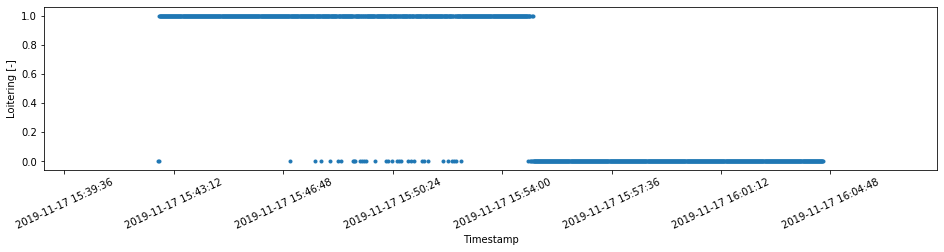

Pre-filter:


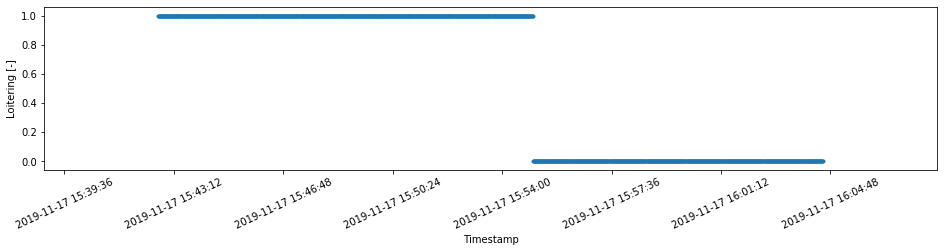

First layer:


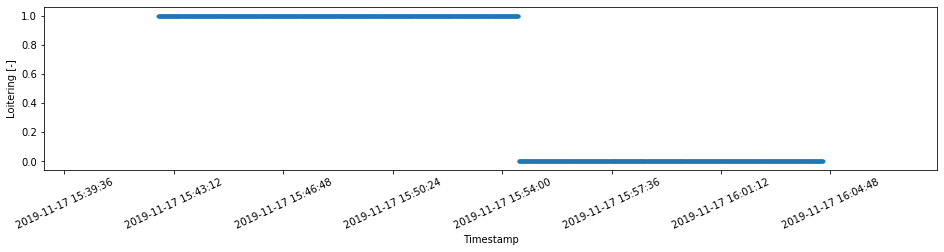

Second layer:


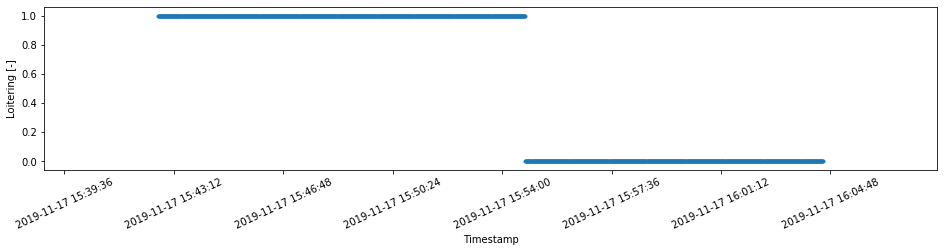

Third layer:


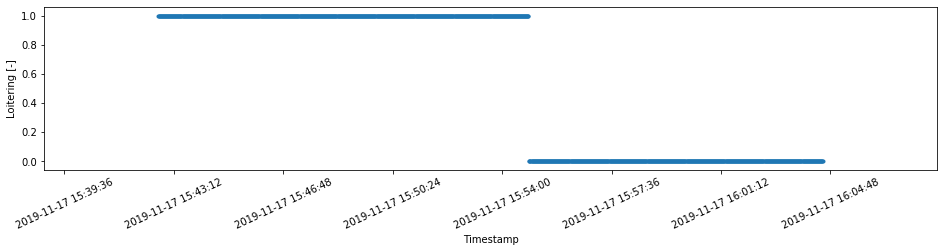

Done


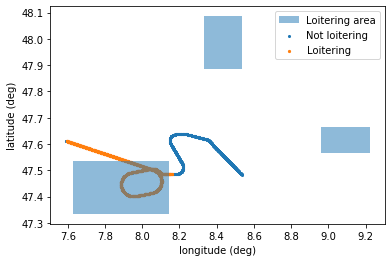

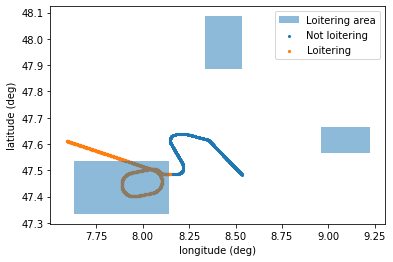

In [21]:
# To export full list, set flight_num to very high number, plotting to False, export to True and plotloiter to False 
# To visualise 1 flight, leave parameters as is
# flight 77 is a good example (flight_num 78, 77 in range)
flight_num = 1
plottraject = True
plotloiter = True
fourthlayer = False
export = False
proces_list = os.listdir(os.getcwd() + '/data/arrival_postprocessed')

if 'arrival_annot_filtered' not in os.listdir(os.getcwd() + '/data'):
    os.mkdir(os.getcwd() + f"/data/arrival_annot_filtered")

for f in range(0, min(len(proces_list), flight_num)):
    file = proces_list[f]
    if file[-4:] == ".csv":
        #print(file)
        data = pd.read_csv(f"data/arrival_postprocessed/{file}")
        
        prefiltered = prefilter(data, clustersize = 10)
        
        firstlayer = filtering(prefiltered, binsize0 = 18, binsizeouter = 15, dist = 15, step = 25)
        
        secondlayer = filtering(firstlayer, binsize0 = 20, binsizeouter = 10, dist = 10, step = 25)

        thirdlayer = filtering(secondlayer, binsize0 = 25, binsizeouter = 20, dist = 12, step = 25)
        
        if not fourthlayer and export:
            thirdlayer.to_csv(f'data/arrival_annot_filtered/{file}', index=False)

        if fourthlayer:
            fourthlayer = filtering(thirdlayer, binsize0 = 25, binsizeouter = 20, dist = 30, step = 25)
            if export:
                fourthlayer.to_csv(f'data/arrival_annot_filtered/{file}', index=False)
                
        if plotloiter:
            print('Original:')
            plotdata(data)
            print("Pre-filter:")
            plotdata(prefiltered)
            print("First layer:")
            plotdata(firstlayer)
            print("Second layer:")
            plotdata(secondlayer)
            print('Third layer:')
            plotdata(thirdlayer)
            if fourthlayer:
                print("Fourth layer:")
                plotdata(fourthlayer)
        
        if plottraject:
            plottraj(data)
            if fourthlayer:
                plottraj(fourthlayer)
            else:
                plottraj(thirdlayer)
        #if thirdlayer["loitering"].sum(axis = 0) <1:
        #    plottraj(thirdlayer)
print("Done")